In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [5]:
# load dataset
data = pd.read_csv("../data/Jan_2020_ontime.csv")

#  data exploration
print("Dataset shape:", data.shape)
print("\nFirst 5 rows:")
print(data.head())

Dataset shape: (607346, 22)

First 5 rows:
   DAY_OF_MONTH  DAY_OF_WEEK OP_UNIQUE_CARRIER  OP_CARRIER_AIRLINE_ID  \
0             1            3                EV                  20366   
1             1            3                EV                  20366   
2             1            3                EV                  20366   
3             1            3                EV                  20366   
4             1            3                EV                  20366   

  OP_CARRIER TAIL_NUM  OP_CARRIER_FL_NUM  ORIGIN_AIRPORT_ID  \
0         EV   N48901               4397              13930   
1         EV   N16976               4401              15370   
2         EV   N12167               4404              11618   
3         EV   N14902               4405              10781   
4         EV   N606UX               4407              14524   

   ORIGIN_AIRPORT_SEQ_ID ORIGIN  ...  DEST  DEP_TIME DEP_DEL15  DEP_TIME_BLK  \
0                1393007    ORD  ...   GRB    1003.0       

In [6]:
# remove missing values 
data = data.dropna(subset=['DEP_TIME', 'OP_UNIQUE_CARRIER', 'DEP_DEL15'])

# create departure hour col
data['DEP_HOUR'] = data['DEP_TIME'].apply(lambda x: int(x/100))

# select features
X = data[['DAY_OF_WEEK', 'DEP_HOUR', 'OP_UNIQUE_CARRIER']]
y = data['DEP_DEL15']

# convert categorical features to dummy variables
X = pd.get_dummies(X, columns=['OP_UNIQUE_CARRIER'], drop_first=True)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# save original features for analysis
original_test_data = data.loc[X_test.index, ['OP_UNIQUE_CARRIER', 'DEP_HOUR']]

# train decision tree
print("\nTraining Decision Tree model...")
dt_model = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=50,
    min_samples_leaf=20,
    random_state=42
)
dt_model.fit(X_train, y_train)


Training Decision Tree model...


DecisionTreeClassifier(max_depth=5, min_samples_leaf=20, min_samples_split=50,
                       random_state=42)


Model Evaluation:
Accuracy: 0.8642304170481978

Confusion Matrix:
[[103778      1]
 [ 16309     42]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      1.00      0.93    103779
         1.0       0.98      0.00      0.01     16351

    accuracy                           0.86    120130
   macro avg       0.92      0.50      0.47    120130
weighted avg       0.88      0.86      0.80    120130



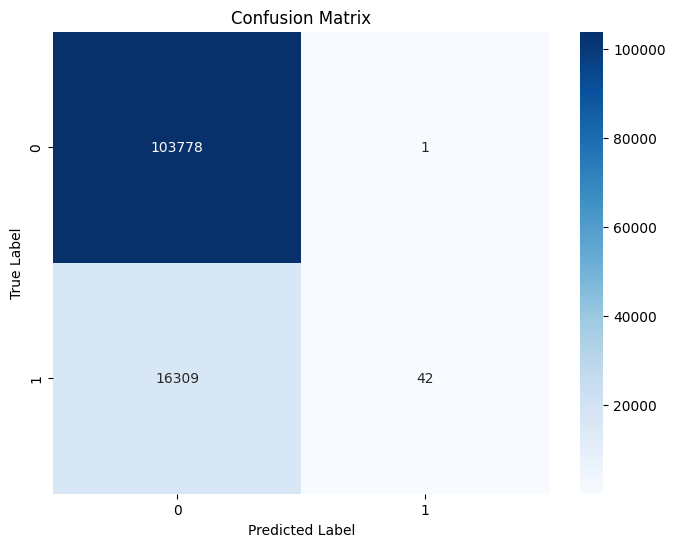

In [7]:
# make predictions
y_pred = dt_model.predict(X_test)

# evaluate model
print("\nModel Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

#  confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

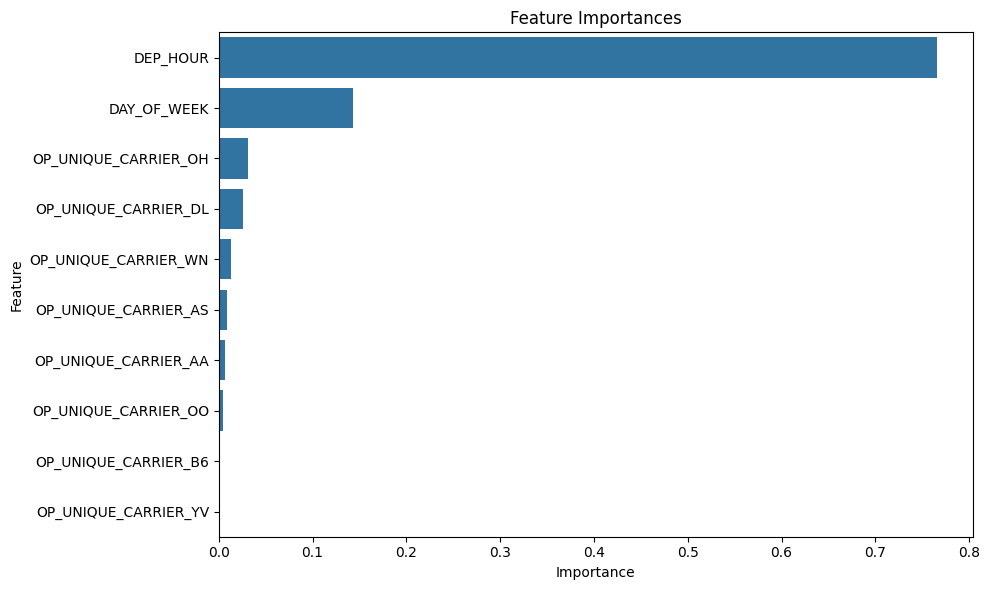


Decision Tree Path Analysis:
Number of leaf nodes used: 31
Most populated leaf node has 23581 samples
Average decision path length: 6.00 nodes

Decision Tree Model Insights:
1. Overall model accuracy: 0.8642
2. Top 3 most important features: ['DEP_HOUR', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER_OH']
3. Best performing carrier: HA with accuracy 0.9163
4. Worst performing carrier: OH with accuracy 0.8122

Overfitting Check:
Training accuracy: 0.8640
Testing accuracy: 0.8642
Difference: -0.0002


C:\Users\eshan\AppData\Local\Temp\ipykernel_3392\2120295092.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  carrier_accuracy = results_df.groupby('Carrier').apply(


In [8]:
#Feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': dt_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

# Analyze performance by carrier
# Create results DataFrame with original carrier information
results_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred,
    'Carrier': original_test_data['OP_UNIQUE_CARRIER'].values,
    'Hour': original_test_data['DEP_HOUR'].values
})

# Calculate accuracy by carrier
carrier_accuracy = results_df.groupby('Carrier').apply(
    lambda x: accuracy_score(x['Actual'], x['Predicted'])
).sort_values(ascending=False)



# decision paths analysis
node_indicator = dt_model.decision_path(X_test)
leaf_id = dt_model.apply(X_test)

# count samples in each leaf node
leaf_samples = pd.Series(leaf_id).value_counts().sort_values(ascending=False)

print("\nDecision Tree Path Analysis:")
print(f"Number of leaf nodes used: {len(leaf_samples)}")
print(f"Most populated leaf node has {leaf_samples.iloc[0]} samples")
print(f"Average decision path length: {node_indicator.sum() / len(X_test):.2f} nodes")

# print insights
print("\nDecision Tree Model Insights:")
print(f"1. Overall model accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"2. Top 3 most important features: {feature_importance['Feature'].iloc[:3].tolist()}")
print(f"3. Best performing carrier: {carrier_accuracy.index[0]} with accuracy {carrier_accuracy.iloc[0]:.4f}")
print(f"4. Worst performing carrier: {carrier_accuracy.index[-1]} with accuracy {carrier_accuracy.iloc[-1]:.4f}")

# compare with training accuracy to check for overfitting
y_train_pred = dt_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"\nOverfitting Check:")
print(f"Training accuracy: {train_accuracy:.4f}")
print(f"Testing accuracy: {test_accuracy:.4f}")
print(f"Difference: {train_accuracy - test_accuracy:.4f}")